<a href="https://colab.research.google.com/github/jakezimm12/Pokemon_Classification_Challenge/blob/main/Pokemon_Classification_Challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [41]:
import pandas as pd
import numpy as np
from numpy import mean
from numpy import std
import scipy.stats as stats
from matplotlib import pyplot
from scipy.stats import chi2_contingency
from scipy import interp
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import chi2, f_classif
from sklearn.datasets import make_classification
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.metrics import roc_curve,auc

In [42]:
### Import Data ###

import io
data = pd.read_csv('https://raw.githubusercontent.com/jakezimm12/Pokemon_Classification_Challenge/main/pokemon_data_science_-_pokemon_data_science.csv')

In [43]:
#### For Reference: ####
name_col_dict = {
'Number': 0, 
'Name': 1,
'Type_1': 2,
'Type_2': 3,
'Total': 4,
'HP': 5,
'Attack': 6,
'Defense': 7,
'Sp_Atk': 8,
'Sp_Def': 9,
'Speed': 10,
'Generation': 11,
'isLegendary': 12,
'Color': 13,
'hasGender': 14,
'Pr_Male': 15,
'Egg_Group_1': 16,
'Egg_Group_2': 17,
'hasMegaEvolution': 18,
'Height_m': 19,
'Weight_kg': 20,
'Catch_Rate': 21,
'Body_Style': 22
}


In [44]:
### Replace NaN Cols ###

# Type_2 has NaN, reasonable to replace with 'Undefined'
data['Type_2'].fillna('Undefined', inplace=True)

# Egg_Group_2 has NaN, reasonable to replace with 'Undiscovered' as in Egg_Group_1
data['Egg_Group_2'].fillna('Undiscovered', inplace=True)

# Pr_Male has NaN, replace with .5 (classification won't work if not valid).
data['Pr_Male'].fillna(.5, inplace=True)

In [45]:
### Find correlated variables to remove ###

# Create correlation matrix
corr_matrix = data.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find features with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

print("Highly correlated features to drop:", to_drop)

# Will perform dropping later for simplicity because we want name_col_dict to continue to be valid

Highly correlated features to drop: ['Generation']


In [46]:
### Perform chi-squared for categorical data ###
# Code from Badiuzzaman Biplob: https://www.linkedin.com/pulse/chi-square-feature-selection-python-md-badiuzzaman-biplob/

class ChiSquare:
    def __init__(self, dataframe):
        self.df = dataframe
        self.p = None #P-Value
        self.chi2 = None #Chi Test Statistic
        self.dof = None
        
        self.dfObserved = None
        self.dfExpected = None

    def _print_chisquare_result(self, colX, alpha):
            result = ""
            if self.p<alpha:
                result="{0} is IMPORTANT for Prediction".format(colX)
            else:
                result="{0} is NOT an important predictor. (Discard {0} from model)".format(colX)

            print(result) 

    def TestIndependence(self,colX,colY, alpha=0.05):
            X = self.df[colX].astype(str)
            Y = self.df[colY].astype(str)
            
            self.dfObserved = pd.crosstab(Y,X) 
            chi2, p, dof, expected = stats.chi2_contingency(self.dfObserved.values)
            self.p = p
            self.chi2 = chi2
            self.dof = dof 
            
            self.dfExpected = pd.DataFrame(expected, columns=self.dfObserved.columns, index = self.dfObserved.index)
            
            self._print_chisquare_result(colX,alpha)

#Initialize ChiSquare Class
cT = ChiSquare(data)
#Feature Selection
testColumns = ['Name', 'Type_1', 'Type_2', 'Generation', 'Color', 'hasGender', 'Egg_Group_1', 'Egg_Group_2', 'hasMegaEvolution', 'Body_Style']
for var in testColumns:
    cT.TestIndependence(colX=var,colY='isLegendary')


Name is NOT an important predictor. (Discard Name from model)
Type_1 is IMPORTANT for Prediction
Type_2 is NOT an important predictor. (Discard Type_2 from model)
Generation is NOT an important predictor. (Discard Generation from model)
Color is NOT an important predictor. (Discard Color from model)
hasGender is IMPORTANT for Prediction
Egg_Group_1 is IMPORTANT for Prediction
Egg_Group_2 is NOT an important predictor. (Discard Egg_Group_2 from model)
hasMegaEvolution is NOT an important predictor. (Discard hasMegaEvolution from model)
Body_Style is NOT an important predictor. (Discard Body_Style from model)


In [47]:
# Perform ANOVA f-test for continuous data ###
# Code from: https://www.programcreek.com/python/example/85917/sklearn.feature_selection.f_classif

print(data)

def f_score(X, y):
    """
    This function implements the anova f_value feature selection (existing method for classification in scikit-learn),
    where f_score = sum((ni/(c-1))*(mean_i - mean)^2)/((1/(n - c))*sum((ni-1)*std_i^2))

    Input
    -----
    X: {numpy array}, shape (n_samples, n_features)
        input data
    y : {numpy array},shape (n_samples,)
        input class labels

    Output
    ------
    F: {numpy array}, shape (n_features,)
        f-score for each feature
    """

    F, pval = f_classif(X, y)
    return F

np_data = data.to_numpy() # convert to numpy

for i in ['Total', 'HP', 'Attack', 'Defense', 'Sp_Atk', 'Sp_Def', 'Speed', 'Pr_Male', 'Height_m', 'Weight_kg']:
  print(i, 'ANOVA F-value:', f_score(np_data[:, [name_col_dict[i]]], np_data[:, 12])[0])


     Number        Name   Type_1  ... Weight_kg  Catch_Rate       Body_Style
0         1   Bulbasaur    Grass  ...       6.9          45        quadruped
1         2     Ivysaur    Grass  ...      13.0          45        quadruped
2         3    Venusaur    Grass  ...     100.0          45        quadruped
3         4  Charmander     Fire  ...       8.5          45   bipedal_tailed
4         5  Charmeleon     Fire  ...      19.0          45   bipedal_tailed
..      ...         ...      ...  ...       ...         ...              ...
716     717     Yveltal     Dark  ...     203.0          45        two_wings
717     718     Zygarde   Dragon  ...     305.0           3  serpentine_body
718     719     Diancie     Rock  ...       8.8           3        head_arms
719     720       Hoopa  Psychic  ...       9.0           3        head_only
720     721   Volcanion     Fire  ...     195.0           3        quadruped

[721 rows x 23 columns]
Total ANOVA F-value: 217.40159811552235
HP ANOVA F-

In [48]:
### Remove desired variables ###
# I kept all numerical data except Pr_Male, which had low F-value.
# I removed all of the highly 'Number,' correlated features, and categorical features based on Chi-Squared Test, as well as Catch_Rate as per instructions.

data = data.drop(columns=['Number', 'Name', 'Type_2', 'Generation', 'Color', 'Pr_Male', 'Egg_Group_2', 'hasMegaEvolution', 'Catch_Rate', 'Body_Style'])


In [49]:
### Prepare Data for Random Forest Classifier ###

# Map booleans to 1-0
data['hasGender'] = data['hasGender'].astype(int)
data['isLegendary'] = data['isLegendary'].astype(int)

# One-hot encode categorical variables
categ_cols = ['Type_1', 'Egg_Group_1']
data = pd.get_dummies(data, columns=categ_cols)

# Since data often has many consecutive legendary rows, shuffle data
data = data.sample(frac=1)

# Separate labels
isLeg = data['isLegendary']
data = data.drop('isLegendary', axis=1)


In [50]:
### Random Forest with Cross Validation ###

# Create Model
rfc = RandomForestClassifier()

# prepare the cross-validation procedure
cv5 = KFold(n_splits=5)
cv10 = KFold(n_splits=10)
# evaluate model
scores5 = cross_val_score(rfc, data, isLeg, scoring='accuracy', cv=cv5, n_jobs=-1)
scores10 = cross_val_score(rfc, data, isLeg, scoring='accuracy', cv=cv10, n_jobs=-1)
# report performance
print('Accuracy for 5-Fold CV: %.3f (%.3f)' % (np.mean(scores5), np.std(scores5)))
print('Accuracy for 10-Fold CV: %.3f (%.3f)' % (np.mean(scores5), np.std(scores5)))

Accuracy for 5-Fold CV: 0.989 (0.007)
Accuracy for 10-Fold CV: 0.989 (0.007)


Random Forest: f1=0.842 auc=0.970


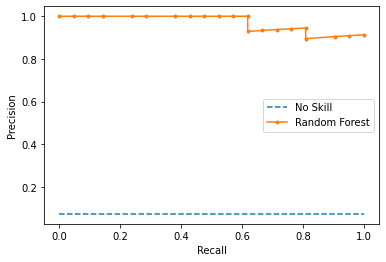

In [63]:
### Precision Recall Curve ###

# # generate 2 class dataset
# X, y = make_classification(n_samples=1000, n_classes=2, random_state=1)
# split into train/test sets
trainX, testX, trainy, testy = train_test_split(data, isLeg, test_size=0.4, random_state=2)

# fit a model
model = rfc
model.fit(trainX, trainy)
# predict probabilities
lr_probs = model.predict_proba(testX)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# predict class values
yhat = model.predict(testX)
lr_precision, lr_recall, _ = precision_recall_curve(testy, lr_probs)
lr_f1, lr_auc = f1_score(testy, yhat), auc(lr_recall, lr_precision)
# summarize scores
print('Random Forest: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
# plot the precision-recall curves
no_skill = len(testy[testy==1]) / len(testy)
pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
pyplot.plot(lr_recall, lr_precision, marker='.', label='Random Forest')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

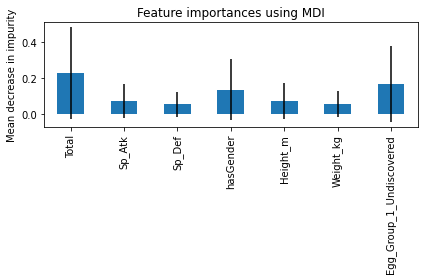

In [52]:
### Feature Importance as Determined by Random Forest ###

feature_names = [col for col in data.columns]
importances = rfc.feature_importances_
std = np.std([tree.feature_importances_ for tree in rfc.estimators_], axis=0)

for i in range(len(feature_names) - 1, -1, -1): #iterate backwards so we don't ruin indexing
  if importances[i] < .05:
    feature_names.pop(i)
    importances = np.delete(importances, i)
    std = np.delete(std, i)

forest_importances = pd.Series(importances, index=feature_names)

fig, ax = pyplot.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()